# Anomaly Detection

## Load Data

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

raw_data = pd.read_csv("./data.csv", parse_dates=['Data'])
raw_data.columns = raw_data.columns.str.replace('Data', 'Date')
raw_data.set_index('Date', inplace=True)
raw_data.sort_index(inplace=True)
raw_data.columns = [col.strip().lower() for col in raw_data.columns]

data_original = raw_data.copy()
data_original.head(5)

,y,xau bgnl,ecsurpus,bdiy,cry,dxy,jpy,gbp,cl1,vix,...,lp01treu,emustruu,lf94truu,mxus,mxeu,mxjp,mxbr,mxru,mxin,mxcn
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,0,283.25,0.077,1388.0,157.26,100.56,105.86,1.646,25.77,22.50,...,116.464,230.527,123.762,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
2000-01-18,0,287.65,0.043,1405.0,165.01,101.86,105.47,1.638,28.85,21.50,...,117.267,231.377,123.762,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2000-01-25,0,287.15,0.135,1368.0,167.24,102.41,106.04,1.650,28.28,23.02,...,117.995,232.390,123.762,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
2000-02-01,0,282.75,0.191,1311.0,166.85,104.92,107.85,1.611,28.22,23.45,...,120.510,231.942,122.328,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
2000-02-08,1,298.40,0.312,1277.0,165.43,104.22,109.30,1.611,28.02,21.25,...,118.791,237.812,122.328,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


## Preprocess Data

### Feature Engineering

In [35]:
def create_moving_features(data, window_size=30):
    ## calculate moving average for each feature
    moving_df = []
    for feat in data:
        moving_df.append(data[feat].rolling(window=window_size).mean().rename(f'{feat}_ma{window_size}'))
        # Use difference between moving average and daily values
        moving_df.append((data[feat] - moving_df[-1]).rename(f'{feat}_diff_ma{window_size}'))
        # Use moving std deviation
        moving_df.append(data[feat].rolling(window=window_size).std().rename(f'{feat}_mstd{window_size}'))
    
    # Concatenate all new columns into a single DataFrame
    return pd.concat(moving_df, axis=1)

data_moving_features = create_moving_features(data_original, 20)
data = pd.concat([data_original, data_moving_features], axis=1)
data.head()

,y,xau bgnl,ecsurpus,bdiy,cry,dxy,jpy,gbp,cl1,vix,...,mxbr_mstd20,mxru_ma20,mxru_diff_ma20,mxru_mstd20,mxin_ma20,mxin_diff_ma20,mxin_mstd20,mxcn_ma20,mxcn_diff_ma20,mxcn_mstd20
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-11,0,283.25,0.077,1388.0,157.26,100.56,105.86,1.646,25.77,22.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-18,0,287.65,0.043,1405.0,165.01,101.86,105.47,1.638,28.85,21.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-25,0,287.15,0.135,1368.0,167.24,102.41,106.04,1.650,28.28,23.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,0,282.75,0.191,1311.0,166.85,104.92,107.85,1.611,28.22,23.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-08,1,298.40,0.312,1277.0,165.43,104.22,109.30,1.611,28.02,21.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Standardize and Cleanup

In [36]:
# dropna
data.dropna(inplace=True)

# standardize data
def standardize_data(data):
  scaler = StandardScaler()
  data_scaled = scaler.fit_transform(data)
  data_transformed_df = pd.DataFrame(data_scaled, index=data.index, columns=data.columns)
  return data_transformed_df

# features + target
target_name = 'y'
y = data[target_name].copy()
X = standardize_data(data).drop(columns=[target_name]).copy()

print("y:", y.shape)
print("X:", X.shape)

y: (1092,)
X: (1092, 171)


In [44]:
print("Column names:", X.columns)

# use convention -1 (anomaly) / 1 (not)
if pd.DataFrame(y.value_counts()).reset_index()['y'].sum() > 0:
  y = y.map(lambda row:  -1 if row == 1 else 1)
target_counts = y.value_counts()
print("Target:", target_counts)

# impurity
impurity = target_counts[-1]/(target_counts[-1] + target_counts[1])
print("impurity", impurity)

Column names: Index(['xau bgnl', 'ecsurpus', 'bdiy', 'cry', 'dxy', 'jpy', 'gbp', 'cl1',
       'vix', 'usgg30yr',
       ...
       'mxbr_mstd20', 'mxru_ma20', 'mxru_diff_ma20', 'mxru_mstd20',
       'mxin_ma20', 'mxin_diff_ma20', 'mxin_mstd20', 'mxcn_ma20',
       'mxcn_diff_ma20', 'mxcn_mstd20'],
      dtype='object', length=171)
Target: y
 1    863
-1    229
Name: count, dtype: int64
impurity 0.2097069597069597


# Build Models

## Unsupervised

### Select features

In [45]:
# select features
feature_names = ['vix', 'bdiy', 'dxy', 'gtdem10y', 'iftruu']

def check_has_feature(string, feature_names):
    return any(substring in string for substring in feature_names)

select_features = X.loc[:, X.columns.map(lambda feat: check_has_feature(feat, feature_names))]
# select_features = features.loc[:, feature_names]

In [46]:
# sklearn to create IsolationForst, OneClassSVM and KernelDensity
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KernelDensity

# sklearn to import classification_report
from sklearn.metrics import classification_report
reports = {}

# Isolation Forest
IF = IsolationForest(n_estimators=400)
IF.fit(select_features)
IF_pred = IF.predict(select_features)
reports['IF'] = classification_report(IF_pred, y, zero_division=0)

# DBSCAN
DB = DBSCAN(eps=80, min_samples=10)
predictions = DB.fit_predict(select_features)
# Map predictions to binary labels: -1 for anomalies, 1 for normal points
binary_predictions = np.where(predictions == -1, -1, 1)
dbscan = pd.DataFrame({'pred': binary_predictions, 'target':y})
reports['DB']=classification_report(dbscan['pred'], dbscan['target'], zero_division=0)

# OneClassSVM Forest
OC = OneClassSVM(nu=impurity)
OC.fit(select_features)
OC_pred = OC.predict(select_features)
reports['OC']=classification_report(OC_pred, y, zero_division=0)

# Kernel Density
KD = KernelDensity()
KD.fit(select_features)
scores = KD.score_samples(select_features)
threshold = np.quantile(scores, impurity)
KD_pred = [-1 if score < threshold else 1 for score in scores]
reports['KD']=classification_report(KD_pred, y, zero_division=0)

**Evaluate**

In [47]:
# sklearn to import classification_report
from sklearn.metrics import classification_report

print(f"For Isolation Forest:\n{reports['IF']}\n\n")
print(f"For DBSCAN:\n{reports['DB']}\n\n")
print(f"For OneClassSVM:\n{reports['OC']}\n\n")
print(f"For Kernel Density:\n{reports['KD']}\n\n")

For Isolation Forest:
              precision    recall  f1-score   support

          -1       0.38      0.63      0.48       140
           1       0.94      0.85      0.89       952

    accuracy                           0.82      1092
   macro avg       0.66      0.74      0.69      1092
weighted avg       0.87      0.82      0.84      1092



For DBSCAN:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           1       1.00      0.79      0.88      1092

    accuracy                           0.79      1092
   macro avg       0.50      0.40      0.44      1092
weighted avg       1.00      0.79      0.88      1092



For OneClassSVM:
              precision    recall  f1-score   support

          -1       0.51      0.50      0.50       234
           1       0.86      0.87      0.87       858

    accuracy                           0.79      1092
   macro avg       0.68      0.68      0.68      1092
weighted avg       

### PCA

In [48]:
dt = pca.explained_variance_ratio_
np.where(np.sort(dt*100)[::-1] > 5, np.sort(dt*100)[::-1], 0)

NameError: name 'pca' is not defined

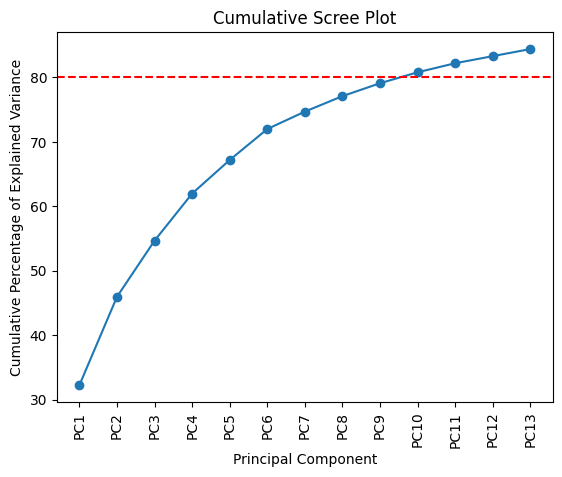

In [49]:
from sklearn.decomposition import PCA

pca = PCA() # use argument to get a limited number of PCs
pca.fit(X)
pca_data = pca.transform(X) # project X on the PCs

# scree plot
explained_variance = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(explained_variance)+1)]

threshold = 1
filtered_per_var = [var for var in explained_variance if var > threshold]
filtered_labels = [label for label in labels if explained_variance[labels.index(label)] > threshold]
cumulative_per_var = np.cumsum(filtered_per_var)
plt.plot(range(1,len(filtered_per_var)+1), cumulative_per_var, marker='o')
plt.xticks(range(1,len(filtered_per_var)+1), filtered_labels, rotation=90)
plt.axhline(y=80, color='r', linestyle='--')
plt.ylabel('Cumulative Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Cumulative Scree Plot')
plt.show()

In [50]:
# Model using PCs
pca = PCA(0.8)
pca.fit(X)
pca_data = pca.transform(X)

# Isolation Forest
IF = IsolationForest(n_estimators=350, contamination=impurity)
IF.fit(pca_data)
IF_pred = IF.predict(pca_data)
reports['PCA_IF'] = classification_report(IF_pred, y)

print(f"For Isolation Forest:\n{reports['PCA_IF']}\n\n")

For Isolation Forest:
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       229
           1       0.86      0.86      0.86       863

    accuracy                           0.79      1092
   macro avg       0.68      0.68      0.68      1092
weighted avg       0.79      0.79      0.79      1092





## Supervised

### Logistic Regression

In [68]:
X = standardize_data(data_original).drop(columns=['y']).copy()
y = data_original['y']

# use convention -1/1
if pd.DataFrame(y.value_counts()).reset_index()['y'].sum() > 0:
  y = y.map(lambda row:  -1 if row == 1 else 1)

# split data
# reserve 2/3 for training and 1/3 for testing
split_index = int(.67 *len(data))
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

from sklearn.linear_model import LogisticRegression

# Create model
lr = LogisticRegression()

# address class imbalance --oversampling the train dataset using SMOTE
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

# train model
lr.fit(X_train_sm, y_train_sm)

# predict
y_pred = lr.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.46      0.40      0.43        47
           1       0.92      0.93      0.93       333

    accuracy                           0.87       380
   macro avg       0.69      0.67      0.68       380
weighted avg       0.86      0.87      0.86       380



### Random Forest

In [72]:
# Create model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = standardize_data(data_original).drop(columns=['y']).copy()
y = data_original['y']

# split data
# reserve 2/3 for training and 1/3 for testing
split_index = int(.67 *len(data))
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# address class imbalance --oversampling the train dataset using SMOTE
from imblearn.over_sampling import SMOTE

smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

# train model
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)

# evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_pred, y_test, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       380
           1       0.00      0.00      0.00         0

    accuracy                           0.89       380
   macro avg       0.50      0.45      0.47       380
weighted avg       1.00      0.89      0.94       380



# Sandbox

In [166]:
# loc with a single row
print(sum(data.loc['2000-08-01'] == data.iloc[0]))
# loc with a single column
print(sum(data.loc[:,'bdiy'] == data['bdiy']))

172
1082


In [168]:
# loc with multiple columns
data.loc[:,['bdiy', 'vix']] == data[['bdiy', 'vix']]

# if using a boolean array, iloc and loc are similar
data.loc[:, np.array([True] + [False] * (data.shape[1] - 1)) ] == data.iloc[:, np.array([True] + [False] * (data.shape[1] - 1)) ]

,y
Date,
2000-08-01,True
2000-08-08,True
2000-08-15,True
2000-08-22,True
2000-08-29,True
...,...
2021-03-23,True
2021-03-30,True
2021-04-06,True


## DBSCAN

### Load dataset

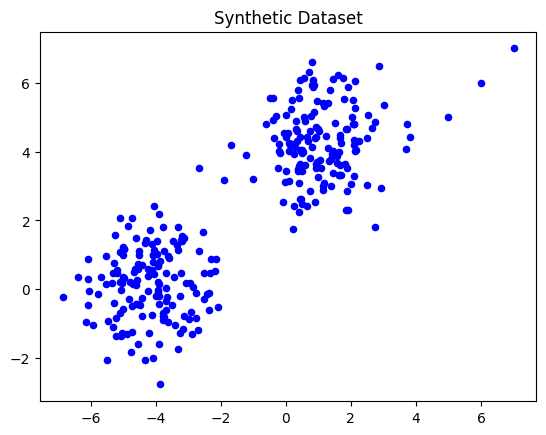

In [2]:
n_samples=300
# Generate isotropic Gaussian blobs for clustering.
X, y = make_blobs(n_samples=n_samples, centers=2, random_state=3, cluster_std=1.0)
anomalies = np.array([[5, 5], [6, 6], [7, 7]])

# Combine the normal data and anomalies
X = np.vstack([X, anomalies])

# Visualize the dataset
plt.scatter(X[:, 0], X[:, 1], c='b', marker='o', s=20) # X[: ,i] -> entire i-th column
plt.title("Synthetic Dataset")
plt.show()

### Apply DBSCAN

In [3]:
# Apply DBSCAN for anomaly detection with increased epsilon
# eps : float, default=0.5
  # The maximum distance between two samples for one to be considered
  # as in the neighborhood of the other. This is not a maximum bound
  # on the distances of points within a cluster.
# min_samples : int, default=5
  # The number of samples (or total weight) in a neighborhood for a point to
  # be considered as a core point. This includes the point itself.
dbscan = DBSCAN(eps=1.5, min_samples=40)
labels = dbscan.fit_predict(X)

# Anomalies are considered as points with label -1
anomalies = X[labels == -1]

Notes:

**model finds the likelihood of being an anomally**
- higher values of eps make model less strict -> finds less anomallies
- higher values of min_samples make the model more strict -> find more anomallies

Conclusions:

* Values of eps and  min_samples are dependant on the nature of data and the size of the dataset

### Visualize

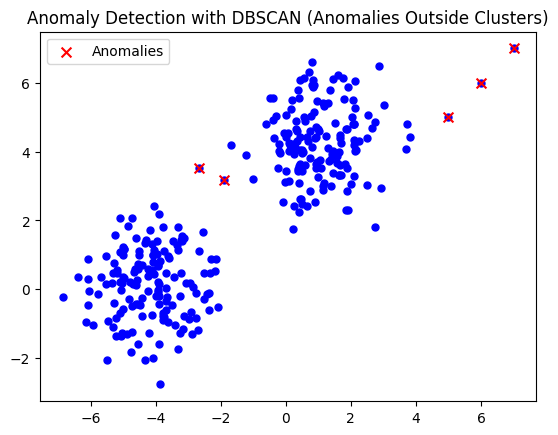

In [4]:
# Visualize the anomalies
plt.scatter(X[:, 0], X[:, 1], c='b', marker='o', s=25)
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', marker='x', s=50, label='Anomalies')
plt.title("Anomaly Detection with DBSCAN (Anomalies Outside Clusters)")
plt.legend()
plt.show()

### EDA

In [36]:
import pandas as pd

raw_data = pd.read_csv("./data.csv", parse_dates=['Data'])
raw_data.columns = raw_data.columns.str.replace('Data', 'Date')

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111 entries, 0 to 1110
Data columns (total 44 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Y          1111 non-null   int64         
 1   Date       1111 non-null   datetime64[ns]
 2   XAU BGNL   1111 non-null   float64       
 3   ECSURPUS   1111 non-null   float64       
 4   BDIY       1111 non-null   float64       
 5   CRY        1111 non-null   float64       
 6   DXY        1111 non-null   float64       
 7   JPY        1111 non-null   float64       
 8   GBP        1111 non-null   float64       
 9   Cl1        1111 non-null   float64       
 10  VIX        1111 non-null   float64       
 11  USGG30YR   1111 non-null   float64       
 12  GT10       1111 non-null   float64       
 13  USGG2YR    1111 non-null   float64       
 14  USGG3M     1111 non-null   float64       
 15  US0001M    1111 non-null   float64       
 16  GTDEM30Y   1111 non-null   float64       


**Univariate**

**Time Series**

In [97]:
raw_data.head(5)

,Y,Date,XAU BGNL,ECSURPUS,BDIY,CRY,DXY,JPY,GBP,Cl1,...,LP01TREU,EMUSTRUU,LF94TRUU,MXUS,MXEU,MXJP,MXBR,MXRU,MXIN,MXCN
0,0,2000-01-11,283.25,0.077,1388.0,157.26,100.56,105.86,1.646,25.77,...,116.464,230.527,123.762,1416.12,127.75,990.59,856.76,224.33,217.34,34.30
1,0,2000-01-18,287.65,0.043,1405.0,165.01,101.86,105.47,1.638,28.85,...,117.267,231.377,123.762,1428.79,129.50,993.98,925.22,234.37,227.08,32.74
2,0,2000-01-25,287.15,0.135,1368.0,167.24,102.41,106.04,1.650,28.28,...,117.995,232.390,123.762,1385.93,126.48,974.83,886.93,216.82,233.00,32.46
3,0,2000-02-01,282.75,0.191,1311.0,166.85,104.92,107.85,1.611,28.22,...,120.510,231.942,122.328,1385.31,129.19,1007.12,842.60,201.89,237.48,31.29
4,1,2000-02-08,298.40,0.312,1277.0,165.43,104.22,109.30,1.611,28.02,...,118.791,237.812,122.328,1411.95,134.67,1034.58,945.15,218.00,258.02,31.32


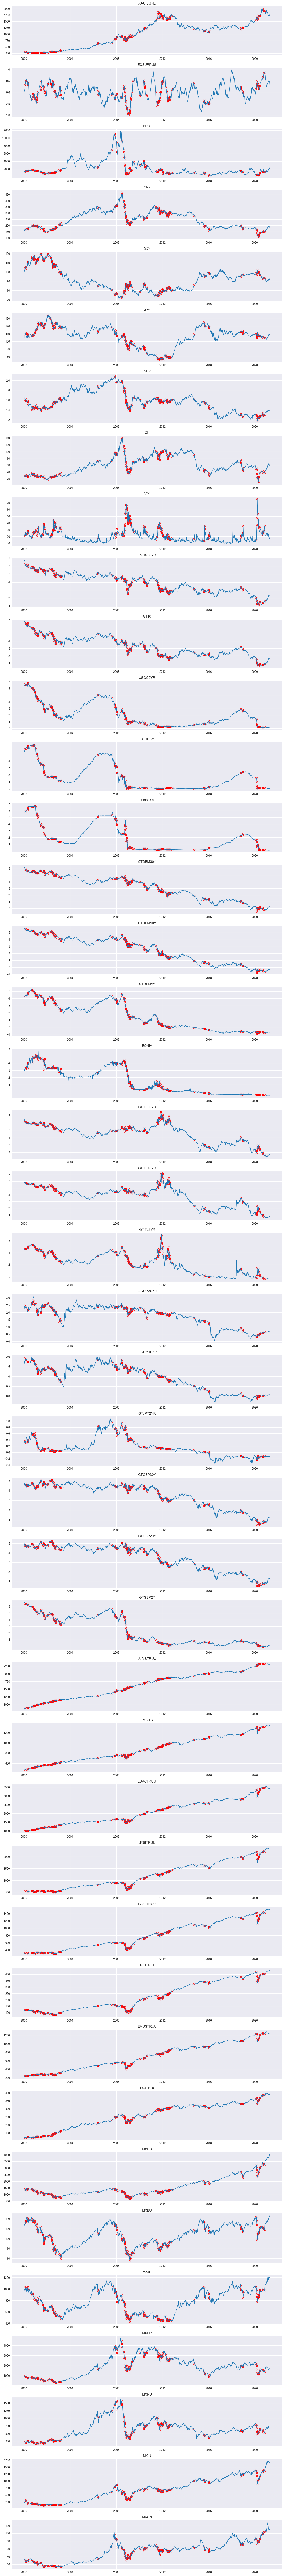

In [100]:
import seaborn as sns

# Set Seaborn style
sns.set_style("darkgrid")

# Identify numerical columns
numerical_columns = raw_data.iloc[:, 2:].select_dtypes(include=["int64", "float64"]).columns

def plot_vertical_lines(plt, date_str):
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='red', linestyle='--')
    pass;

# Plot time series for each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx) # create new subplot with index idx
    plt.plot(raw_data['Date'], raw_data[feature]) # plot values in the y axis with 'Date' as x-axis labels

    # plot_vertical_lines(plt, "2008-01-01")
    # plot_vertical_lines(plt, "2020-01-01")

    raw_data_anom = raw_data[raw_data["Y"]==1]
    plt.scatter(raw_data_anom['Date'], raw_data_anom[feature], color='red', marker='x')


    plt.title(feature)

# Adjust layout and show plots
plt.tight_layout()
plt.show()

**Box Plots**

ECSURPUS (np.float64(-0.86825), np.float64(0.9377500000000001)) 0.991
BDIY (np.float64(-1553.25), np.float64(5228.75)) 11793.0
GBP (np.float64(1.0287500000000005), np.float64(2.06675)) 2.085
Cl1 (np.float64(-20.3975), np.float64(139.6625)) 140.97
VIX (np.float64(-1.3374999999999986), np.float64(38.6025)) 75.91
USGG2YR (np.float64(-2.9512500000000004), np.float64(6.454750000000001)) 6.872
USGG3M (np.float64(-3.2782500000000008), np.float64(5.703750000000001)) 6.414
US0001M (np.float64(-3.1512499999999997), np.float64(5.89475)) 6.776
GTJPY2YR (np.float64(-0.4225), np.float64(0.6215)) 1.08
MXUS (np.float64(-228.85500000000002), np.float64(3325.225)) 4043.69
MXRU (np.float64(-32.44250000000005), np.float64(1289.2575000000002)) 1617.64
MXCN (np.float64(-31.277500000000018), np.float64(128.3025)) 129.2


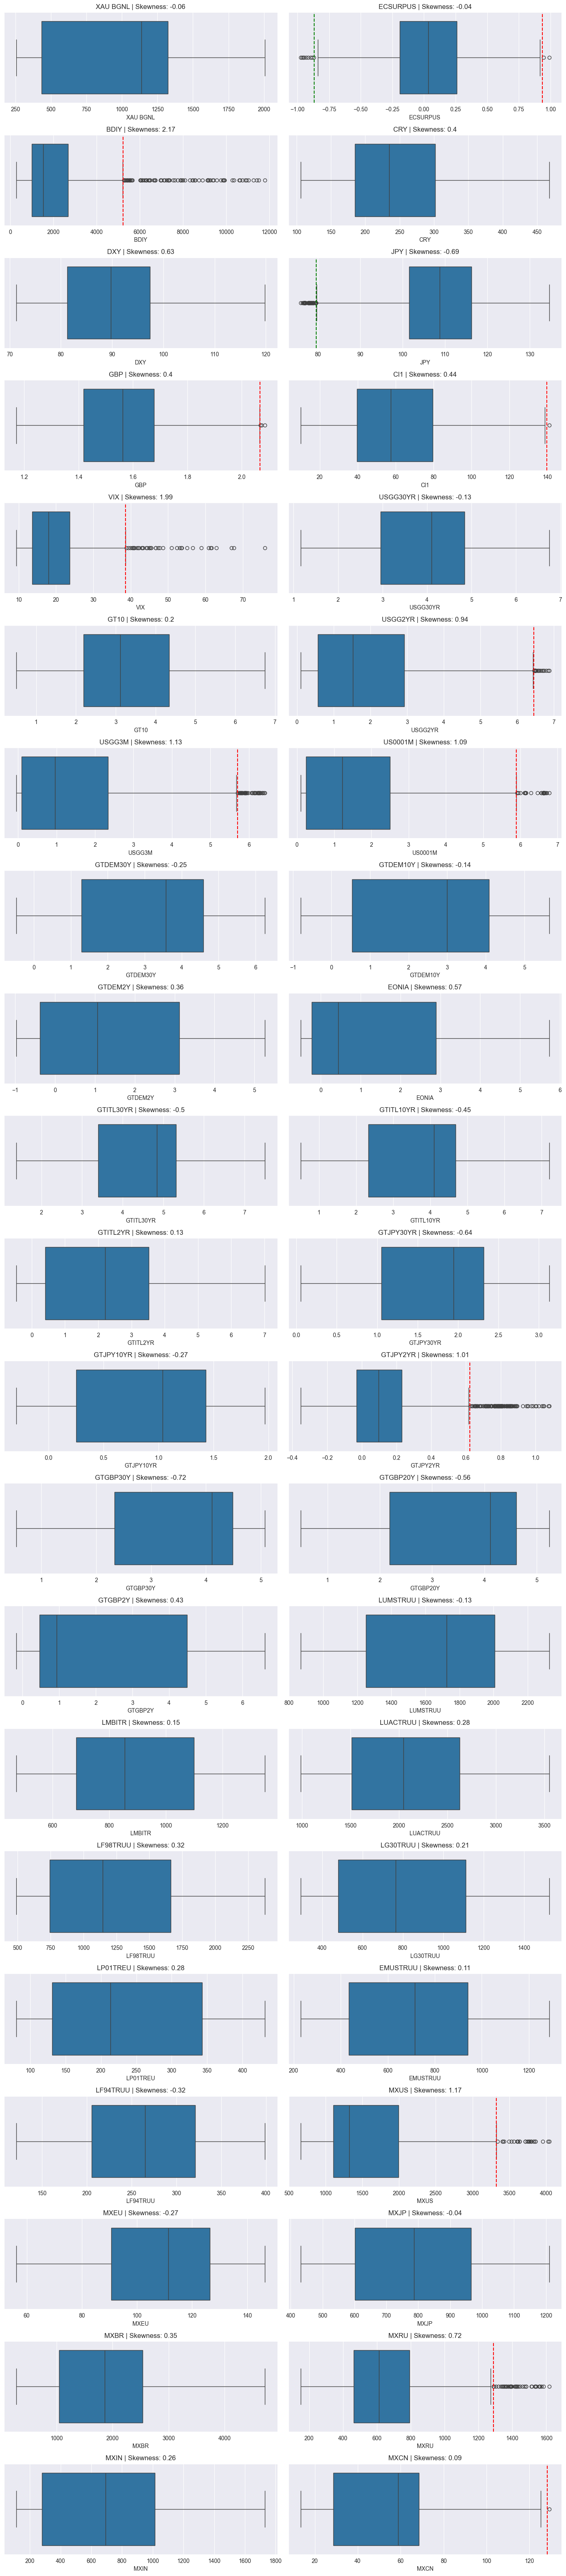

In [83]:
import seaborn as sns

# Set Seaborn style
sns.set_style("darkgrid")

# Identify numerical columns
numerical_columns = raw_data.iloc[:, 2:].select_dtypes(include=["int64", "float64"]).columns

def plot_vertical_lines(plt, x_axis, color='red'):
    plt.axvline(x=x_axis, color=color, linestyle='--')
    pass;

# Plot boxplot for each numerical feature
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.boxplot(x=raw_data[feature])
    plt.title(f"{feature} | Skewness: {round(raw_data[feature].skew(), 2)}")
    interq = raw_data[feature].quantile(0.75) - raw_data[feature].quantile(0.25)
    thresh = (raw_data[feature].quantile(0.25) - 1.5 * interq, raw_data[feature].quantile(0.75) + 1.5 * interq)
    if(raw_data[feature].min() < thresh[0]):
      plot_vertical_lines(plt, thresh[0], 'green')
    if(raw_data[feature].max() > thresh[1]):
      print(feature, thresh, raw_data[feature].max())
      plot_vertical_lines(plt, thresh[1])

# Adjust layout and show plots
plt.tight_layout()
plt.show()

### Correlation

In [13]:
# Assuming 'df' is your DataFrame
plt.figure(figsize=(15, 10))

# Using Seaborn to create a heatmap
mask = np.triu(np.ones_like(raw_data.iloc[:,2:].corr(), dtype=bool))
sns.heatmap(raw_data.iloc[:,2:].corr(), annot=False, cmap='YlGnBu', linewidths=2, mask=mask)

plt.title('Correlation Heatmap')
plt.show()

NameError: name 'sns' is not defined

<Figure size 1500x1000 with 0 Axes>


Fold 1 - Original class distribution:
y
0    0.728571
1    0.271429
Name: proportion, dtype: float64

Fold 2 - Original class distribution:
y
0    0.739677
1    0.260323
Name: proportion, dtype: float64

Fold 3 - Original class distribution:
y
0    0.755396
1    0.244604
Name: proportion, dtype: float64

Detailed Results by Fold:

Fold 1:
Test size: 277
Crisis ratio in test set: 0.751
AUC Score: 0.786

Confusion Matrix:
[[208   0]
 [ 69   0]]

Fold 2:
Test size: 277
Crisis ratio in test set: 0.787
AUC Score: 0.683

Confusion Matrix:
[[216   2]
 [ 58   1]]

Fold 3:
Test size: 277
Crisis ratio in test set: 0.881
AUC Score: 0.644

Confusion Matrix:
[[244   0]
 [ 33   0]]

Average Metrics Across Folds:
accuracy: 0.805 ± 0.055
precision_crisis: 0.807 ± 0.055
recall_crisis: 0.997 ± 0.004
f1_crisis: 0.891 ± 0.033
auc: 0.704 ± 0.060


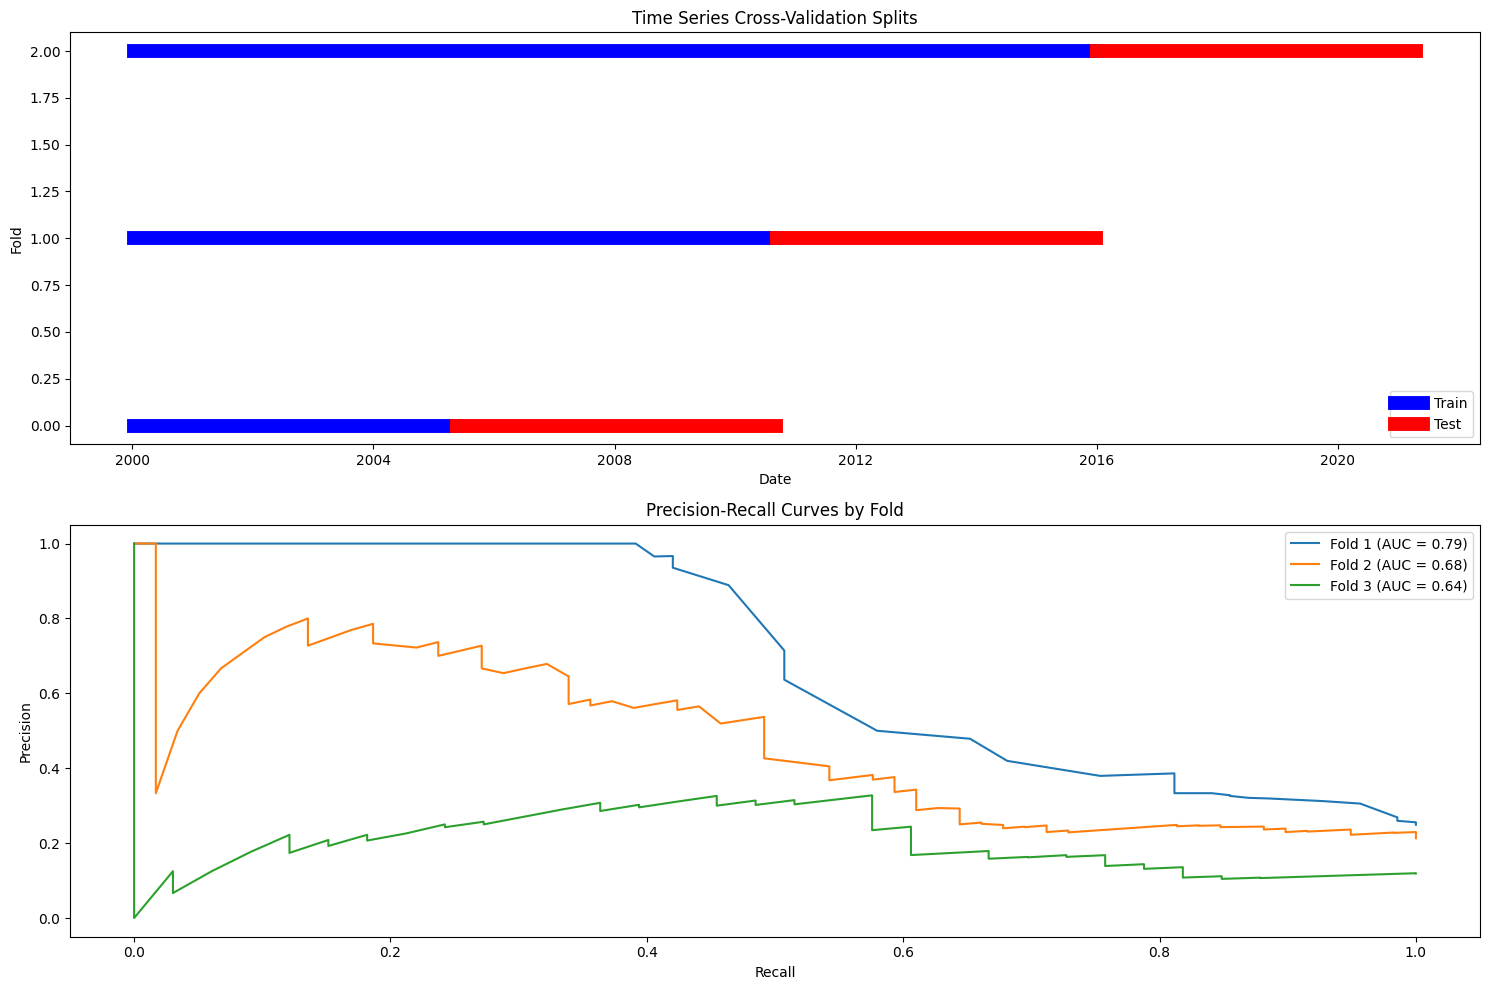

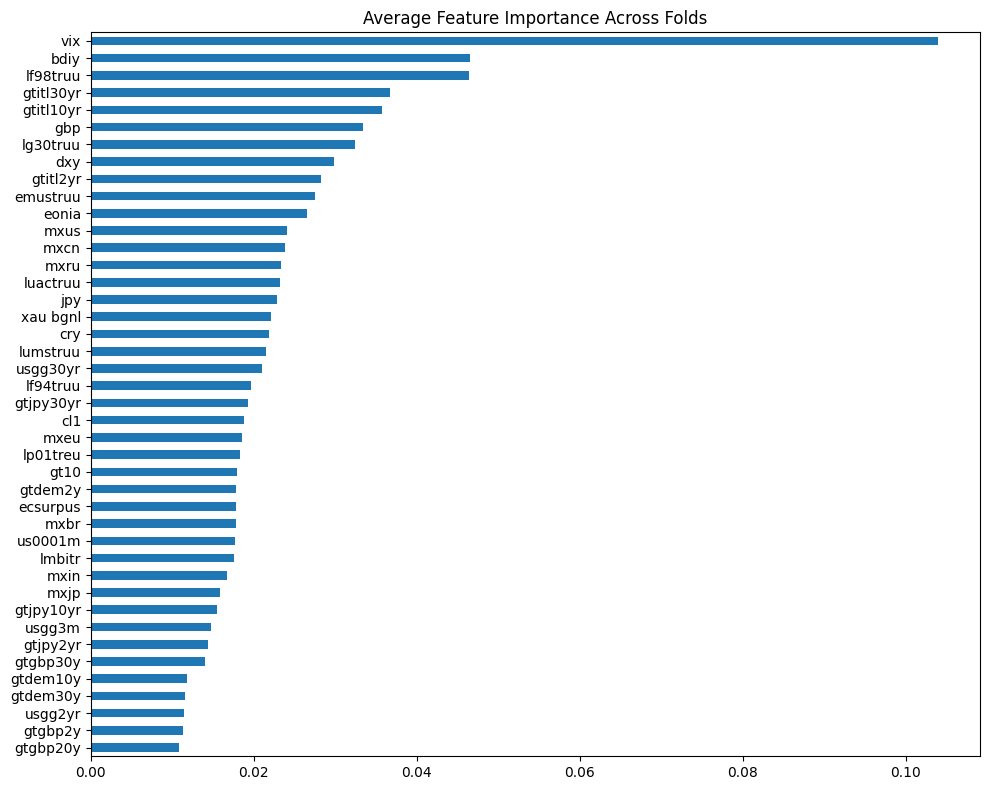

In [14]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

def prepare_and_evaluate_model(data, target_col='y', n_splits=3, crisis_label=-1):
    """
    Prepare and evaluate model with proper time series split and evaluation
    Parameters:
    - data: DataFrame with features and target
    - target_col: name of target column
    - n_splits: number of splits for time series cross-validation
    - crisis_label: label used for crisis periods (-1 or 0)
    """
    # Setup variables
    X = data.drop(columns=[target_col])
    y = data[target_col].copy()
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Store results
    results = []
    feature_importance_sum = np.zeros(len(X.columns))
    
    # Plot setup
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Convert back to DataFrame
        X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
        
        # Print class distribution
        print(f"\nFold {fold + 1} - Original class distribution:")
        print(pd.Series(y_train).value_counts(normalize=True))
        
        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        
        # Train model with balanced class weights
        rf = RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_estimators=200,
            max_depth=10
        )
        rf.fit(X_train_balanced, y_train_balanced)
        
        # Predict probabilities and classes
        y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
        y_pred = rf.predict(X_test_scaled)
        
        # Calculate metrics
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        fold_results = {
            'fold': fold + 1,
            'test_size': len(y_test),
            'crisis_ratio': 1 - y_test.mean(),  # Ratio of crisis periods
            'report': classification_report(y_test, y_pred, output_dict=True, zero_division=0),
            'auc_score': auc_score,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        results.append(fold_results)
        
        # Accumulate feature importance
        feature_importance_sum += rf.feature_importances_
        
        # Plot this fold's split
        axes[0].plot([X.index[train_idx[0]], X.index[train_idx[-1]]],
                    [fold, fold], 'blue', linewidth=10, label='Train' if fold == 0 else '')
        axes[0].plot([X.index[test_idx[0]], X.index[test_idx[-1]]],
                    [fold, fold], 'red', linewidth=10, label='Test' if fold == 0 else '')
        
        # Plot precision-recall curve for this fold
        axes[1].plot(recall, precision, label=f'Fold {fold+1} (AUC = {auc_score:.2f})')
    
    # Finalize plots
    axes[0].set_title('Time Series Cross-Validation Splits')
    axes[0].set_ylabel('Fold')
    axes[0].set_xlabel('Date')
    axes[0].legend()
    
    axes[1].set_title('Precision-Recall Curves by Fold')
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].legend()
    plt.tight_layout()
    
    # Feature importance plot
    plt.figure(figsize=(10, 8))
    feature_importance = pd.Series(
        feature_importance_sum / n_splits,
        index=X.columns
    ).sort_values(ascending=True)
    feature_importance.plot(kind='barh')
    plt.title('Average Feature Importance Across Folds')
    plt.tight_layout()
    
    return results, feature_importance

def print_results_summary(results):
    """
    Print detailed summary of model performance
    """
    avg_metrics = {
        'accuracy': [],
        'precision_crisis': [],
        'recall_crisis': [],
        'f1_crisis': [],
        'auc': []
    }
    
    print("\nDetailed Results by Fold:")
    for r in results:
        print(f"\nFold {r['fold']}:")
        print(f"Test size: {r['test_size']}")
        print(f"Crisis ratio in test set: {r['crisis_ratio']:.3f}")
        print(f"AUC Score: {r['auc_score']:.3f}")
        print("\nConfusion Matrix:")
        print(r['confusion_matrix'])
        
        # Store metrics
        avg_metrics['accuracy'].append(r['report']['accuracy'])
        avg_metrics['precision_crisis'].append(r['report']['0']['precision'])  # 0 is crisis class
        avg_metrics['recall_crisis'].append(r['report']['0']['recall'])
        avg_metrics['f1_crisis'].append(r['report']['0']['f1-score'])
        avg_metrics['auc'].append(r['auc_score'])
    
    print("\nAverage Metrics Across Folds:")
    for metric, values in avg_metrics.items():
        print(f"{metric}: {np.mean(values):.3f} ± {np.std(values):.3f}")

results, feature_importance = prepare_and_evaluate_model(data_original, crisis_label=-1)
print_results_summary(results)